# Functionality 3
### Importing

In [43]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import deque
from ipywidgets import HTML
import folium
from folium import Map, Marker, GeoJson, LayerControl
from IPython.display import Image
from folium import plugins

### getting paths for files

In [2]:
path = os.getcwd()+'\\Data'
path_dist = path + '\\distance.gr'
path_info = path + '\\node_info.co'
path_trav_time = path + '\\travel_time.gr'

### Reading Data from files

In [3]:
def clean_data(path):
    with open(path, 'r') as x: # to open the file 
        lst = x.readlines() # to have access to each line
        out = [] # initializing a list to put all the content from the file that we are opening
        for i in lst: # iterating on each line
            row = i[2:-1] # from each row we take from the second element to the second-last because in the original file there is "a" in the beginning and "\n" at the end of the row
            out.append(row) # in the out list we append each cleaned row
        clean_out = out[7:] # we take from the 7th row to the last one, this because in the original file in the first 7 rows there are data in which we are not interested
        clean_out2 = [] # initializing a new list to put all the number in form "list of list, where each list inside contain 3 elements, the first node the second one and the distance"
        for j in range(len(clean_out)):
            clean_out2.append(list(map(int, clean_out[j].split()))) # we do the last step by the split function       
    return clean_out2 # and at the end this function give out the list of list cleaned from the file that we have opened

In [4]:
#loading data from the file
dist = clean_data(path_dist)
time = clean_data(path_trav_time)
info = clean_data(path_info)

### Functionality 3 
####  Implementation of Graph Data Structure and Dijsktra's Algorithm

In [5]:
#vertex class to store details of each node
class Vertex:
    def __init__(self,key):
        self.id = key #node name or number
        self.connectedTo = {}
        self.coordinate =()
    def addNeighbor(self,nbr,weight=0):
        self.connectedTo[nbr.getId()] = weight
    #def __str__(self):
        #return str(self.id) + ' connectedTo: ' + str([x.id for x in self.connectedTo])
        #return self.id
    #method to return the nodes or vertices which are connected to the vertex x
    def getConnections(self):
        return self.connectedTo.keys()
    #method to return the id of the vertex object
    def getId(self):
        return self.id
    #method to return the weight of the 
    def getWeight(self,nbr):
        if nbr not in self.connectedTo:
            return -1
        else:
            return self.connectedTo[nbr]
    #method to return coordinates of node for visualization
    #initially will be empty we have to load data to it
    def getCoord(self):
        return self.coordinate
    #to load coordinate
    def setCoord(self,longitude,latitude):
        self.coordinate = tuple([latitude,longitude])
#class "Graph" to create a graph
class Graph:
    #dictionary of list of vertices of vertex objects
    def __init__(self):
        self.vertList = {}
        self.numVertices = 0
    #method to add vertex
    def addVertex(self,key):
        self.numVertices = self.numVertices + 1
        #creating vertex object
        newVertex = Vertex(key)
        #storing corresponding vertext object reference in dictionary
        self.vertList[key] = newVertex
        return newVertex
    #pass name of the vertex it will return corresponding vertex object
    #if none present it will return -1
    def getVertex(self,n):
        if n in self.vertList:
            return self.vertList[n]
        else:
            return -1
    
    def __contains__(self,n):
        return n in self.vertList
    #method to add edges
    def addEdge(self,f,t,weight=0):
        #if either of vertex not in the graph adding vertex to graph
        if f not in self.vertList:
            nv = self.addVertex(f)
        if t not in self.vertList:
            nv = self.addVertex(t)
        #adding edge afterwards
        self.vertList[f].addNeighbor(self.vertList[t], weight)
    #method to get vertices
    def getVertices(self):
        return self.vertList.keys()

    def __iter__(self):
        return iter(self.vertList.values())
    #method to find the shortest route between v1 and v2 vertices using dijsktra algorithm
    def find_shortest(self, start, end):
        if self.getVertex(start)!= -1 and self.getVertex(end)!=-1 :
            #shortest paths stored in below dictionary
            paths = {start: (None, 0)}
            #current vertex
            current = start
            #to keep track of nodes that are already visited
            visited = set()
            #till we reach destination loop through and find path
            while current != end:
                #add current vertex to the visited set
                visited.add(current)
                #get the nodes that are reachable from current vertex
                dest = self.getVertex(current).getConnections()
                #current weight of the path
                weight_current = paths[current][1]

                for next_vertex in dest:
                    #checking weights of the next reachable vertex from current vertex
                    weight = self.getVertex(current).getWeight(next_vertex)+ weight_current
                    #if its shortest path store it 
                    if next_vertex not in paths:
                        paths[next_vertex] = (current, weight)
                    else:
                        current_shortest_weight = paths[next_vertex][1]
                        if current_shortest_weight > weight:
                            paths[next_vertex] = (current, weight)
                #get all the destination from the current vertex
                next_dest = {node: paths[node] for node in paths if node not in visited}
                #if there is no rechable return -1 as it not possible
                if not next_dest:
                    return -1
                # next vertex is the destination with the lowest weight
                current = min(next_dest, key=lambda k: next_dest[k][1])

            # Walk back through dest in shortest path
            path = []
            weights = []
            while current is not None:
                path.append(current)
                next_vertex = paths[current][0]
                weights.append(paths[current][1])
                current = next_vertex
            # reverse the path and return along with weight
            path = path[::-1]
            return weights[0],path
        else:
            return -1
    
    

### Method for Visualization

In [45]:
#create a visulaization for graph
def visualize_graph(path_latlongs):
    iconstart = Icon(icon_url='https://img.icons8.com/ultraviolet/40/000000/marker.png', 
                     icon_size=[40, 40], icon_anchor=[20,40])
    iconend = Icon(icon_url="https://img.icons8.com/officexs/16/000000/marker.png", 
                       icon_size=[40, 40], icon_anchor=[20,40])

    m = Map(location=path_latlongs[0],zoom_start=17)
    folium.PolyLine(path_latlongs).add_to(m)
    walkData = {}
    walkData['coordinates'] = path_latlongs
    folium.GeoJson(walkData, name='walk').add_to(m)
    folium.PolyLine(path_latlongs, color="red", weight=2.5, opacity=1).add_to(m)
    m.save("index.html")
    return m

### Creating Graph

In [7]:
#creating graph
G1 = Graph()
#Adding edges to graph thus making vertices too
for i in range(len(dist)):
    #vertex1,vertex2,distance or time or even empty it will construct graph with weight 1
    G1.addEdge(dist[i][0],dist[i][1],dist[i][2])
    
#Adding coordinates detail to the vertices 
for i in range(len(info)):
    #mandatory step to check first whether the vertex present in graph or not if getvertex method return -1 
    if G1.getVertex(info[i][0])== -1 :
        print("Vertex not present ",info[i])
    else:
        G1.getVertex(info[i][0]).setCoord(int(info[i][1])/1000000,int(info[i][2])/1000000 )

### Getting Input From the User and Printing the Output

In [8]:
#Getting Input from the User
while True:
    print("Enter Starting Node")
    H = input()
    if H.isalpha()==True:
        print("Enters Numbers only : Try Again")
        continue
    H = int(H)
    if G1.getVertex(H) == -1:
        print("Node not present in the Graph!!! Try again")
    else:
        break
    print("Try Again")
print("Please Enter the sequence of Nodes one by one: (press enter to end)")
p=[]
while True:
    temp = input()
    if temp== "":
        break
    p.append(int(temp))
print(H,p)
#Finding Shortest ordered path
Flag = -1
current = H
weight = 0 
shortest_path = []
for i in range(len(p)):
    A = G1.find_shortest(current,p[i])
    if  A == -1 :
        print("Not Possible")
    else:
        w = A[0]
        path = A[1]
        shortest_path+= path[:-1]
        weight+=w
        current = p[i]
shortest_path.append(p[-1])
print("Shorted Path,Distance")
print(shortest_path,weight)

Enter Starting Node
21
Please Enter the sequence of Nodes one by one: (press enter to end)
22
23
24

21 [22, 23, 24]
Shorted Path,Distance
[21, 1048596, 1048595, 24, 23, 61, 1048625, 1048628, 65, 1048629, 66, 80, 1048641, 2319, 1048593, 22, 1048593, 2319, 1048641, 80, 66, 1048629, 65, 1048628, 1048625, 61, 23, 24] 295986


### Collecting Data for Visualization

In [26]:
la = []
lo = []
path_latlongs = []
for vertex in shortest_path:
    X = G1.getVertex(vertex).getCoord()
    la.append(X[0])
    lo.append(X[1])
    path_latlongs.append([X[0],X[1]])

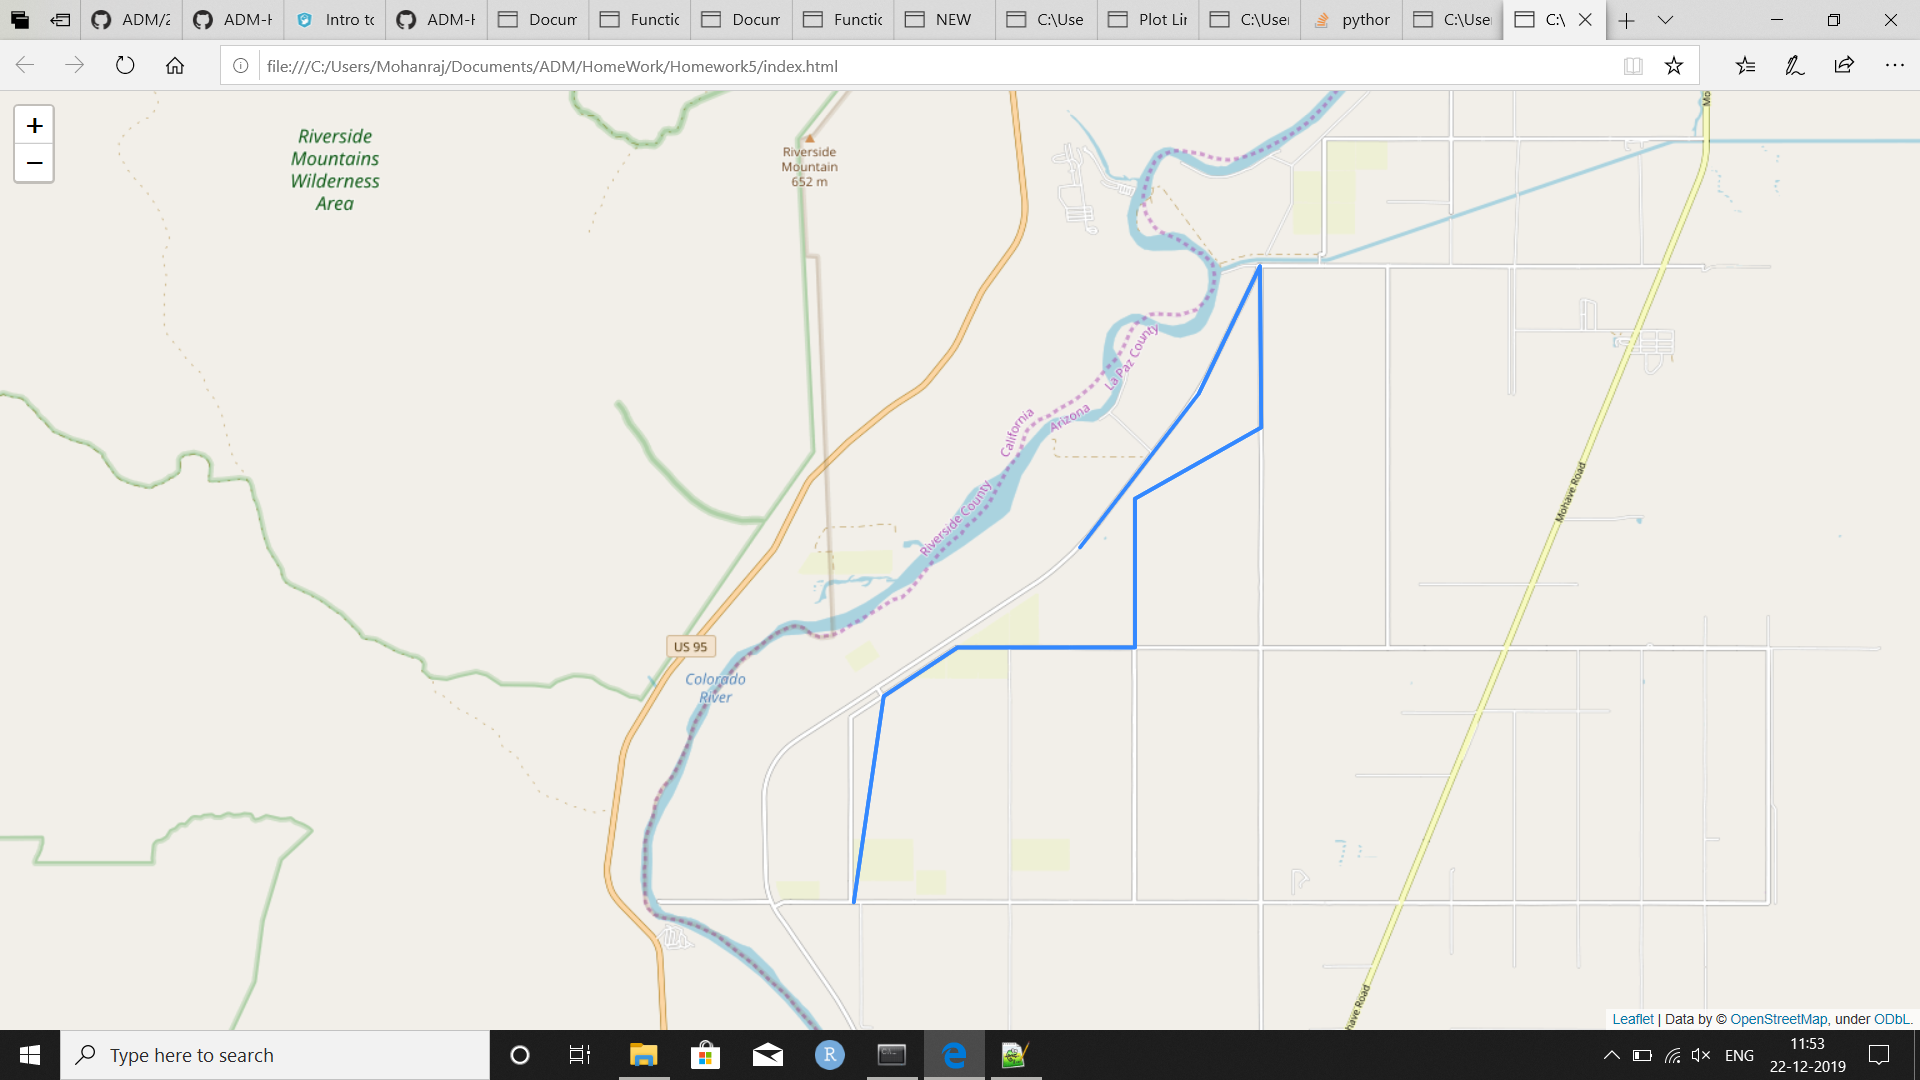

In [47]:
visualize_graph(path_latlongs)
Image("map_result.png")